# MNIST

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from edward.models import Categorical, Normal, Empirical
import edward as ed
import pandas as pd

Use the TensorFlow method to download and/or load the data

In [2]:
mnist = input_data.read_data_sets("MNIST_data/",one_hot = True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Task is to classify the handwritten MNIST digits into one of the classes {0,1,2,...,9} and give a measure of the uncertainty of our classification. 
* Our machine learning model will be a simple soft-max regression, and for this we first need to choose a likelihood function to quantify the probability of the observed data given a set of parameters (weights and biases in our case). 

* We will use a Categorical likelihood function (see Chapter 2, Machine Learning: a Probabilistic Perspective by Kevin Murphy for a detailed description of Categorical distribution, also called Multinoulli distribution.).


We next set up some placeholder variables in TensorFlow. 
* This follows the same procedure as you would for a standard neural network except that we use Edward to place priors on the weights and biases. 
* In the code below, we place a normal Gaussian prior on the weights and biases.

In [3]:
# ed.set_seed(314159)
N = 500   # number of images in a minibatch.
D = 784   # number of features.
K = 10    # number of classes.

In [4]:
# Create placeholder to hold the data (in minibatches) in a Tensorflow graph
x = tf.placeholder(tf.float32,shape=[None,D])
# y = tf.placeholder(shape=[None,K])
# Normal (0,1 priors for variables)
w = Normal(loc=tf.zeros([D,100]), scale = tf.ones([D,100]))
b = Normal(loc=tf.zeros(100), scale = tf.ones(100))

w2 = Normal(loc=tf.zeros([100,K]), scale = tf.ones([100,K]))
b2 = Normal(loc=tf.zeros(K), scale = tf.ones(K))

# h = tf.matmul(x,w)+b 


def simple_nn(x,w,w1,b,b1):
    h = tf.nn.softmax(tf.matmul(x,w)+b)
    y = tf.nn.softmax(tf.matmul(h,w1)+b1)
    return y

# Categorical likelihood for classification
y = Categorical(simple_nn(x,w,w2,b,b2))

Up to this point we have defined the likelihood P(y|x,;ω)P(y|x,;ω) and the prior P(ω)P(ω), next we want to use Bayes rule to compute the posterior P(ω|y,x)P(ω|y,x)

However, we immediately face a problem because in practice the probability of the outputs P(y)P(y) is computationally intractable to compute for large instances and so we don't attempt to calculate the posterior directly.

To tackle this problem we will instead be using Variational Inference (VI). In Variational Inference we choose a family of parameterised distributions Q(ω;λ)Q(ω;λ) over parameters ωω to approximate the true posterior, and then optimize the parameters λλ so as to match the true posterior distribution as best as possible. The core idea is to minimise what is known as the Kullback-Leibler divergence between the true posterior P(ω|y,x)P(ω|y,x) and the approximating ditribution Q(ω;λ)Q(ω;λ), which can be thought of as a measure of the disimilarity between two probability distributions.


The theory behind VI is beyond the scope of this blog, so more more information a quick introduction to VI can be found in Edward's documentation and a detailed one in Variational Inference: A Review for Statisticians by Blei et al.. Chapter 33 or MacKay's book is also a very good reference.

So next we use Edward to set up the approximating distributions Qw(ω)Qw(ω) for the weights and Qb(ω)Qb(ω) for the biases:

In [5]:
# Contruct the q(w) and q(b). in this case we assume Normal distributions.
# qw = Normal(loc=tf.Variable(tf.random_normal([D,100])),
#                            scale = tf.nn.softmax(tf.Variable(tf.random_normal([D,100]))))# dim of weights
# qb = Normal(loc=tf.Variable(tf.random_normal([100])),
#            scale = tf.nn.softmax(tf.Variable(tf.random_normal([100]))))

# qw1 = Normal(loc=tf.Variable(tf.random_normal([100,K])),
#                            scale = tf.nn.softmax(tf.Variable(tf.random_normal([100,K]))))# dim of weights
# qb1 = Normal(loc=tf.Variable(tf.random_normal([K])),
#            scale = tf.nn.softmax(tf.Variable(tf.random_normal([K]))))

In [5]:
# # SGHMC
qw =  Empirical(params=tf.Variable(tf.zeros([50000,D,100])) )
qb = Empirical(params=tf.Variable(tf.zeros([50000,100])))
qw_1 =  Empirical(params=tf.Variable(tf.zeros([50000,100,K])) )
qb_1 = Empirical(params=tf.Variable(tf.zeros([50000,K])))

In [6]:
# We use a placeholder for the labels in anticipation of the training data
y_ph = tf.placeholder(tf.int32, [N])
# Define the VI inference technique, ie. minimize the KL divergence between q and p
inference = ed.SGHMC({w: qw, b: qb, w2: qw_1, b2: qb_1}, data={y:y_ph})

In [8]:
# # We use a placeholder for the labels in anticipation of the training data
# y_ph = tf.placeholder(tf.int32, [N])
# # Define the VI inference technique, ie. minimize the KL divergence between q and p
# inference = ed.SGHMC({w: qw_1, b: qb_1}, data={y:y_ph})
# inference.run(step_size=1e-4)

In [9]:
# inference.initialize(n_iter=5000, n_print=100, scale={y: float(mnist.train.num_examples) / N})

In [7]:
###### Initalize the inference variables
# Q: what does this do?!
inference.initialize(n_iter=25000, n_print=100,step_size=1e-4, scale={y: float(mnist.train.num_examples) / N})

 Now we are ready to perform Variational Inference. 
 We load up a TensorFlow session and start the iterations. Will take a few minutes.

In [8]:
# tf.reset_default_graph()
# We will use an interactive session
sess = tf.InteractiveSession()
# Initalize all the variables in the session
tf.global_variables_initializer().run()

In [9]:
# Train model. 
# We load data in minibatches and update the VI inference using each new batch
for _ in range(inference.n_iter):
    X_batch, Y_batch = mnist.train.next_batch(N)
    # Tensorflow method, gives the label data in a one hot vector format.
    # We convert taht into a single label
    Y_batch = np.argmax(Y_batch, axis=1)
    info_dict = inference.update(feed_dict={x: X_batch, y_ph: Y_batch})
    inference.print_progress(info_dict)

50000/50000 [100%] ██████████████████████████████ Elapsed: 734s | Acceptance Rate: 1.000


# Evaluate Model

We now have everything that we need to run our model on the test data, let's see how good our model is! 

The major difference in Bayesian model evaluation is that there is no single value for the weights and biases that we should use to evaluate the model.

 Instead we should use the distribution of weights and biases in our model so that the uncertainties in these parameters are reflected in the final prediction.

Thus instead of a single prediction we get a set of predictions and their accuracies.

We draw a 100 samples from the posterior distribution and see how we perform on each of these samples. Taking samples be might a slow process, may take few seconds!

In [10]:
# Load test images
X_test = mnist.test.images
# Tensorflow method gives the label data in a hot vector format. WE convert to single label.
Y_test = np.argmax(mnist.test.labels,axis=1)

In [17]:
# Generate samples the posterior and store them
n_samples = 100
prob_lst = []
samples = []
w_samples = []
b_samples = []

w_samples2 = []
b_samples2 = []

for i in range(30):
    print i
    w_samp = qw.sample()
#     print w_samp.shape
    b_samp = qb.sample()
    
    w_samp2 = qw_1.sample()
#     print w_samp.shape
    b_samp2 = qb_1.sample()
    
    w_samples.append(w_samp)
    b_samples.append(b_samp)
    w_samples2.append(w_samp2)
    b_samples2.append(b_samp2)
    # Also compute the probability of each class for each (w,b) sample.
    h = tf.nn.softmax(tf.matmul(X_test,w_samp) + b_samp)
    prob= tf.nn.softmax(tf.matmul(h,w_samp2) + b_samp2)
    
    
    prob_lst.append(prob.eval())
    w_samp_reshape = tf.reshape(w_samp,[-1])
    sample = tf.concat([w_samp_reshape,b_samp],0)
    samples.append(sample.eval())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [18]:
# Compute the accuracy of the model.

accy_test = []
for prob in prob_lst:
    # For each sample we compute the predicted class and compare with the test labels
    y_trn_prd = np.argmax(prob, axis=1).astype(np.float32)
    # Predicted class is defined as the one which has maximum probability
    # We preform this test for each (w,b) in the posterior giving us a set of accuracies
    acc = (y_trn_prd == Y_test).mean()*100
    accy_test.append(acc)

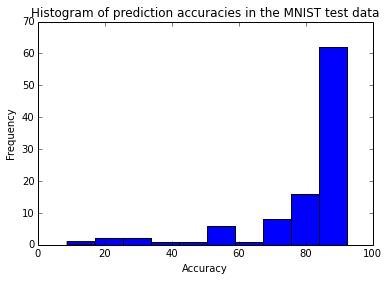

In [19]:
# Finally we make a histogram of accuracies for the test data.
plt.hist(accy_test)
plt.title("Histogram of prediction accuracies in the MNIST test data")
plt.xlabel("Accuracy")
plt.ylabel("Frequency")

In [20]:
# Here we compute the mean of probabilties for each class for all the (w,b) samples.
# We then use the class with maximum of the mean proabilities as the prediction. 
# In other words, we have used (w,b) samples to construct a set of models and
# used their combined outputs to make the predcitions.
Y_pred = np.argmax(np.mean(prob_lst,axis=0),axis=1)
print("accuracy in predicting the test data = ", (Y_pred == Y_test).mean()*100)

('accuracy in predicting the test data = ', 92.640000000000001)
